# Full Technical Report: Where's the American Dream?
**_Exploring Intergenerational Economic Mobility by U.S. County_**

Nateé Johnson  
January 2020

### Overview

The goal of the project was to model and visualize Absolute Upward Mobility (AUM) by county as a function of location-specific characteristics. The aim was to determine which features of a county elevated a low-income child’s opportunity to achieve greater economic outcomes than their parents. My approach was to make a definition of what it meant for a county to be a hotbed of opportunity (a.k.a “Mobile”) versus a place where average upward mobility is hampered (a.k.a “Not Mobile”).  Using binary classification models, I looked at `feature importance` to determine which characteristics of a child’s neighborhood impact their economic outcomes.

I encountered missing data (missingno library) and class imbalances (~10% of the counties met the criteria to be labeled as “Mobile”). To address class imbalance, I experimented with SMOTE (Synthetic Minority Oversampling Technique) and the `class_weight` parameter.

I found the Random Forest classifier had greater distinguishing power than the logistic regression model. 
I used python’s Folium library to generate a multi-layer choropleth map with pop-up markers and a dynamic tooltip. 



### Imports
Import libraries and write settings here.

#### External Libraries & Packages

In [84]:
# Data manipulation
import pandas as pd
import pickle
import numpy as np
from pandas_profiling import ProfileReport
import os
import sys

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30


# Visualizations
import chart_studio.plotly as py
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

# Anaylsis & Modeling Packages
from imblearn.over_sampling import SMOTE
from inspect import signature
from operator import itemgetter
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, average_precision_score, precision_recall_curve, classification_report
from sklearn import tree 
from IPython.display import Image  



#### Local Scripts

Import functions to produce styled confusion matrix

In [46]:
src_dir = os.path.join(os.getcwd(), '..', '..', 'src')
sys.path.append(src_dir)

from d04_visualisation.styled_confusion import plot_confusion_matrix

In [48]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          size=(10, 6),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Parameters
    ----------
    y_true: list-like
        test/true values
    
    y_pred: list-like
        predicted values
        
    classes: list
        names of classes which predictions can fall into
        
    normalize: bool
        normalize the results (default False, do not normalize)
        
    title: str
        title of confusion matrix
        
    size: tuple (ordered pair)
        height and width in which the figure will display
        
    Returns
    -------
    ax: axis
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    #classes = class_names
    
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

## Data Exploration

### Data Sources & Cleaning

The following section defines the two data sources used in this project. The csv files were orginially inspected with Excel/Numbers. Access to the raw data is provided in [data/01_raw](../../data/01_raw) and links to original sources are provided in each section. 

#### Opportunity Insights

**Original Study:** Where is the Land of Opportunity? *The Geography of Intergenerational Mobility in the United States*  
**Authors:** Chetty, Hendren, Kline and Saez (2014)  
**Publication:** Descriptive Statistics by County and Commuting Zone http://www.equality-of-opportunity.org/assets/documents/mobility_geo.pdf  
**Data source**: http://www.equality-of-opportunity.org/data/ 

Opportunity Insights is a massive effort exploring the topic of Intergenerational Economic Mobility. Researchers from Harvard University, Brown University and the Census Bureau, compiled decades of data from tax returns, W-2s, and U.S. census survey results to link parents and children. Looking at parents’ income and their age at childbirth, they traced those children to adulthood and captured their income at a comparable age.

**Cleaning Summary:** 
- CSV provided has several sheets. Relevant data is in sheet named "Online Data Table 3". There is substantial metadata in top of sheet, and column headers are multi-indexed. 
- The appropriate column names are preserved by transposing the dataframe, resetting the index with the column names, dropping the level 1 index, then restoring the dataframe to a tidy format with another tranpose. 
- By transposing the dataframe, the datatypes reverted to `objects`. Changed the appropriate columns back to `float`.   


In [3]:
# This brings in the data while maintaing a multi-indexed column information
county_stats = pd.read_excel('../../data/01_raw/Equality_Opportunity/online_data_tables.xls',
                             sheet_name='Online Data Table 3',
                             header=[29, 30])


# Transposing dataframe to remove first level of multi-indexed column headers
county_wo_multidx = county_stats.T.reset_index(level=1, drop=True).T

# Transposing the dataframe changes the datatypes, so here we restore the appropriate columns to floats
county_mobility = pd.concat([county_wo_multidx.iloc[:, :5],
                             county_wo_multidx.iloc[:, 5:].astype('float')], axis=1)

**Additional Processing**  
For the purposes of binary classification modeling, I will define two categories: "Mobile" and "Not Mobile". *Mobile* means that, on average, a child growing up in a given location is able to move up at least 25 centiles from their parents. 
- Adding column "rank_diff" as my definition of a "Mobile" county, and making boolean column
- 0 is False, meaning a county is NOT considered mobile by my definition. [2804 counties]
- 1 is True, meaning a county IS considered mobile. [337 counties]

In [4]:
county_mobility['rank_diff'] = county_mobility['Absolute Upward Mobility'] - 25

county_mobility['Target'] = (county_mobility.rank_diff >= 25).astype('int')

# Padding FIPS code so the formatting will match when it's time to merge with next dataset
county_mobility['County FIPS Code'] = county_mobility['County FIPS Code'].apply(
    lambda x: str(x).zfill(5))  

# Exporting data as pkl into new notebook for modeling
#county_mobility.to_pickle('../../data/02_intermediate/county_mobility_incomeOnly')

In [5]:
## Using Pandas Profiling library for comprehensive look at data

ProfileReport(county_mobility)

**Summary**  
Each row is a distinct County (indicated by unique FIPS codes).   
Data is available for 2769 of 3141 counties

#### County Health Rankings

**Original Access:** (sourced from Tableau Public)    
https://public.tableau.com/s/sites/default/files/media/County_Health_Rankings.csv  
**Authors:** County Health Rankings & Roadmaps
**Data Origin:** (available by individual year)  
https://www.countyhealthrankings.org/app/

"The County Health Rankings & Roadmaps is a collaboration between the Robert Wood Johnson Foundation and University of Wisconsin Population Health Institute. The annual County Health Rankings measure vital health factors including high school graduation rates, obesity, smoking, unemployment, quality of air and water, etc."

**Cleaning Summary:** 
- Ensured State, County and FIPS codes were read in as `string` type. The 5 digit FIPS code is a combination of the State and County codes. The data is provided where each row is either a national, state, or county aggregration. Filtering out State and Country level data leaves 298920 rows remaining!
- Each row is a different measure, and not a unique county. Therefore, creating a dataframe that is long by County and wide by each measure, which is averaged value from all available years for that given measure.

In [6]:
CH_ranking = pd.read_csv('../../data/01_raw/County_Health_Rankings.csv',
                         dtype={'State code': 'str', 'County code': 'str', 'fipscode': 'str'})

In [8]:
CH_ranking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303864 entries, 0 to 303863
Data columns (total 14 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   State                            303858 non-null  object 
 1   County                           303858 non-null  object 
 2   State_code                       303860 non-null  object 
 3   County_code                      303860 non-null  object 
 4   Year_span                        303390 non-null  object 
 5   Measure_name                     303390 non-null  object 
 6   Measure_id                       303390 non-null  float64
 7   Numerator                        214076 non-null  float64
 8   Denominator                      184779 non-null  float64
 9   Raw_value                        289956 non-null  float64
 10  Confidence_Interval_Lower_Bound  189412 non-null  float64
 11  Confidence_Interval_Upper_Bound  189412 non-null  float64
 12  Da

In [10]:
# Changing County code to string with 3-characters
CH_ranking['County_code'] = CH_ranking['County_code'].apply(
    lambda x: str(x).zfill(3))

# Changing State code to string with 2-characters
CH_ranking['State_code'] = CH_ranking['State_code'].apply(
    lambda x: str(x).zfill(2))

# Changing FIPS code to string with 5-characters
CH_ranking['fipscode'] = CH_ranking['fipscode'].apply(
    lambda x: str(x).zfill(5))

# Filter out State and Country level data = 298920 rows remaining
county_only = CH_ranking.loc[(CH_ranking['County_code'] != '000') & (
    CH_ranking['fipscode'] != '00nan')]

county_measures = pd.DataFrame(county_only.groupby(
    by=['fipscode', 'Measure_name'])['Raw_value'].mean())

county_measures.reset_index(inplace=True)

# Creating table that is long by County and wide by each measure is averaged value from all available
# years for given measure.
county_meas_piv = county_measures.pivot(
    index='fipscode', columns='Measure_name', values='Raw_value')

#county_meas_piv.to_pickle('../../data/02_intermediate/county_measures')

In [11]:
ProfileReport(county_meas_piv)

### Merging Datasets

More detailed walk-through can be found in this notebook: [notebooks/02_processing/20190911-ndj-Merging_Health_Income_tables.ipynb](../02_processing/20190911-ndj-Merging_Health_Income_tables.ipynb)

Merged income and county health data on FIPS code, then created two versions of the data: 
- one with missing values dropped
- the other having the median imputed for missing values 

Testing to see difference in modeling outcomes based on how the missing data is handled. Does is effect models discriminatory power? 

In [12]:
# Using data that was just cleaned
county_income = pd.read_pickle('../../data/02_intermediate/county_mobility_incomeOnly') 
county_health = pd.read_pickle('../../data/02_intermediate/county_measures')

In [13]:
county_income.set_index("County FIPS Code", drop=False, inplace=True)

county_merged = county_health.merge(
    county_income, how='outer', left_index=True, right_index=True)

# Rearranging Columns 
cols = list(county_merged.columns)

columns = ['County FIPS Code','County Name',
 'Commuting Zone ID','Commuting Zone Name ',
 'State','Target', 'rank_diff', 'Number of Children in Core Sample',
 'Rank-Rank Slope','Absolute Upward Mobility',
 'Top 1% Income Share','Interquartile Income Range', 'Share Between p25 and p75',
 'Mean Parent Income', 'Mean Child Income','Parent Income P25',
 'Child Income P25', 'Median Parent Income', 'Median Child Income','Parent Income P75',
 'Child Income P75', 'Parent Income P90', 'Child Income P90', 'Parent Income P99',
 'Child Income P99', 'Gini',
 'Teenage Birth Rate', 'Adult obesity','Children in poverty',
 'Daily fine particulate matter','Diabetic screening',
 'Mammography screening','Physical inactivity',
 'Premature Death','Preventable hospital stays',
 'Sexually transmitted infections', 'Unemployment',
 'Uninsured','Violent crime rate']

county_merged = county_merged[columns]

# There appear to be 81 counties for which no information exists. 
# I will drop those rows, first. 

# county_merged.dropna(subset=['County FIPS Code']).shape

# Dropping all null values leaves 2688 rows of data
merged_DropNA_all = county_merged.dropna() 

# Imputing perserves 3141 rows of data
median = dict(county_merged.describe().loc['50%',:])
county_merged_imputed = county_merged.fillna(value = median)


# county_merged_imputed.to_pickle('../../data/03_processed/county_merged_imputed')
# merged_DropNA_all.to_pickle('../../data/03_processed/county_merged_dropped_NaNs')


### Data Decisions

insert image of original data set and talk about decision to average over years '97-'02

Given missing values, date ranges, etc. I will proceed using: 




## Analysis/Modeling

An thought overview of the analysis
- The first subsection chases the question:   
*"Within a county, can income distribution alone offer strong distinguishing power between "Mobile" and "Not Mobile" places?"*
  
  
- The second subsection chases the question:   
*"Within a county, of the available attributes/features, which ones are most important in distinguishing between "Mobile" and "Not Mobile" places?"*

### Modeling on Income Data Only

Decision Tree and Logistic Regression

In choosing features to model on, I am conscious of data leakage and auto-correlation (?). 

In [14]:
county_mobility = pd.read_pickle('../../data/02_intermediate/county_mobility_incomeOnly')
county_health = pd.read_pickle('../../data/02_intermediate/county_measures')

#### Setting up data

Dropping rows with null values (~11.8% of the data)

In [15]:
features = [
    'Top 1% Income Share',
    'Interquartile Income Range',
    'Median Parent Income'
]

X = county_mobility.dropna(subset=features, axis=0)[features]
y = county_mobility.dropna(subset=features, axis=0)[['Target']]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=5)

In [17]:
display(X.shape, y.shape)

(2769, 3)

(2769, 1)

**SMOTE - Addressing Imbalanced Classes**

In [18]:
smote = SMOTE(random_state=42, sampling_strategy=1)
X_res, y_res = smote.fit_resample(X_train, y_train) # np.array(y_train).ravel())

#### Decision Tree 1 - (dropped rows w/ missing data)

In [19]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

**Performance Metrics**

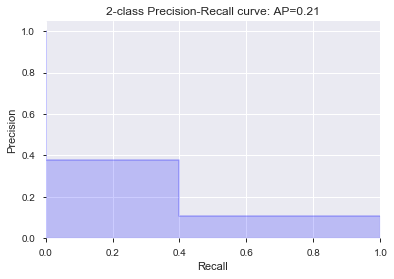

In [20]:
accuracy_score(y_test, y_pred)
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [21]:
confusion_matrix(y_test, y_pred), average_precision_score(y_test, y_pred)

(array([[685,  58],
        [ 53,  35]]), 0.21346088696443882)

**Result Summary**

Initial model exploration: 

 - Split data into 70:30 Train:Test
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Null values were dropped
 - Only specified `criterion='entropy'`
 
Results: 
 - Model accuracy was 0.866 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.23 (The ratio of correct positive predictions to the total predicted positives) (means I'm OVER predicting Mobility)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - Run same data through logistic regression which will report the likelihood of being classified as Mobile based on the combination of features

#### Decision Tree 2 - (w/ SMOTE )

Given unbalanced class, used SMOTE to resample the data. Now using X_res and y_res for fitting. 

In [22]:
# instantiating and fitting 2nd tree
clf_res = DecisionTreeClassifier(criterion='entropy', max_depth=2)
clf_res.fit(pd.DataFrame(X_res), pd.DataFrame(y_res))
y_res_pred = clf_res.predict(X_test)

**Performance Metrics**

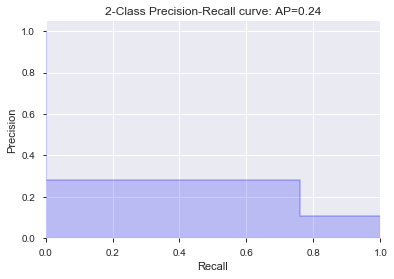

In [23]:
accuracy_score(y_test, y_res_pred)
average_precision_score(y_test, y_res_pred)
average_precision2 = average_precision_score(y_test, y_res_pred)
precision2, recall2, _ = precision_recall_curve(y_test, y_res_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall2, precision2, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall2, precision2, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-Class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision2))
plt.show()

**Result Summary**

- Used split data into 70:30 Train:Test (dropped nulls)
 - Did SMOTE on X_train, y_train
 - Only specified `criterion='entropy'`
 
Results: 
 - Model accuracy was 0.767 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.238 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - Run same data through second logistic regression which will report the likelihood of being classified as Mobile based on the combination of features

#### Logistic Regression 1

In [24]:
# Using sklearn first (but no p-values)
regr = LogisticRegression(C=1e5, solver='liblinear')

# train the model using the training sets
regr.fit(np.array(X_train), np.array(y_train).ravel())

prediction = regr.predict(X_test)

**Performance Metrics & Plotting**

In [27]:
display(accuracy_score(y_test, prediction),
        average_precision_score(y_test, prediction))

0.8856799037304453

0.1698595390560801

In [30]:
# plt.figure(1, figsize=(4, 3))
# plt.clf()
# #plt.scatter(np.array(X).ravel(), np.array(y).ravel(), color='black', zorder=20)

# loss = np.array(expit(X_test * regr.coef_ + regr.intercept_)).ravel()
# plt.scatter(np.array(X_test).ravel(), loss, color='red', linewidth=3)

# # ols = linear_model.LinearRegression()
# # ols.fit(X, y)
# # plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
# # plt.axhline(.5, color='.5')

# plt.ylabel('y')
# plt.xlabel('X')
# # plt.xticks(range(-5, 10))
# # plt.yticks([0, 0.5, 1])
# # plt.ylim(-.25, 1.25)
# # plt.xlim(-4, 10)
# plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
#            loc="lower right", fontsize='small')
# plt.tight_layout()
# plt.show()

In [31]:
# # Variables needed for plotting the distribution: 

# # store the coefficients
# coef = regr.coef_
# interc = regr.intercept_
# # create the linear predictor
# lin_pred= (X * coef + interc)
# # perform the log transformation
# mod_income = 1 / (1 + np.exp(-lin_pred))
# # sort the numbers to make sure plot looks right
# age_ordered, mod_income_ordered = zip(*sorted(zip(age ,mod_income.ravel()),key=lambda x: x[0]))

# # Plotting the distribution

# fig = plt.figure(figsize=(8,6))
# fig.suptitle('logistic regression', fontsize=16)
# plt.scatter(age, income_bin)
# plt.xlabel("age", fontsize=14)
# plt.ylabel("monthly income", fontsize=14)
# plt.plot(age_ordered, mod_income_ordered, c = "black")
# plt.show()

**Results Summary**

Initial model exploration: 

 - Used same split data from decision tree: 
     - had to make the y_train a 1-d array
     - null values were dropped
 - Predicted likelihood of county being classified as "Mobile" (0=false, 1=true) based solely on 
     - 'Top 1% Income Share'
     - 'Interquartile Income Range'
     - 'Median Parent Income'
 - Only specified `C=1e5, solver='liblinear'`
 
Results: 
 - Model accuracy was 0.886 (Accuracy is defined as the ratio of correctly predicted examples by the total examples.)
 - Average Precision Score = 0.170 (The ratio of correct positive predictions to the total predicted positives)
     - this means I said a lot of counties were mobile when they really aren't

Next steps:
 - do SMOTE to addressed imbalanced classes
 - compare to using `class_weight` parameter


#### Logistic Regression 2 - (SMOTE vs "balanced")

In [32]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr = LogisticRegression(C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr.fit(np.array(X_train), np.array(y_train).ravel())
prediction = regr.predict(X_test)
accuracy_score(y_test, prediction), average_precision_score(y_test, prediction)

(0.7713598074608905, 0.2482901556175473)

In [33]:
# Using SMOTE data instead of balanced classes, to compare the performance of SMOTE vs. the module's balancing
regr2 = LogisticRegression(C=1e5, solver='liblinear')

# train the model using the SMOTE-resampled training sets
regr2.fit(np.array(X_res), np.array(y_res).ravel())
y_res_pred2 = regr2.predict(X_test)
accuracy_score(y_test, y_res_pred2), average_precision_score(y_test, y_res_pred2)

(0.7821901323706378, 0.2570729920992474)

**Results Summary**

Using 'balanced' class_weight in the Logistic Regression instance:

`Accuracy Score = 0.771`  
`Precision = 0.248 ` 

Using SMOTE data instead of balanced classes

`Accuracy Score = 0.782  `  
`Precision = 0.257  `

### Modeling on Merged County Income & Health Data

Using: Decision Tree, Logistic Regression, Random Forest

In this series an additional performance metric will be included, the Receiver Operator Characteristic curve (ROC curve). The ROC curve illustrates the true positive rate against false positive rate of our classifier.

Recall = the True Positive Rate  (the ratio of the true positive predictions compared to all values that are actually positive)

The ROC curve gives us a graph of the tradeoff between this false positive and true positive rate. The AUC, or area under the curve, gives us a singular metric to compare these. An AUC of 1 being a perfect classifier, and an AUC of .5 being that which has a precision of 50%.

In [71]:
# Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

#### Setting up data

In [34]:
county_imputed = pd.read_pickle('../../data/03_processed/county_merged_imputed')
county_dropped = pd.read_pickle('../../data/03_processed/county_merged_dropped_NaNs')

In [36]:
county_imputed.columns

Index(['County FIPS Code', 'County Name', 'Commuting Zone ID',
       'Commuting Zone Name ', 'State', 'Target', 'rank_diff',
       'Number of Children in Core Sample', 'Rank-Rank Slope',
       'Absolute Upward Mobility', 'Top 1% Income Share',
       'Interquartile Income Range', 'Share Between p25 and p75',
       'Mean Parent Income', 'Mean Child Income', 'Parent Income P25',
       'Child Income P25', 'Median Parent Income', 'Median Child Income',
       'Parent Income P75', 'Child Income P75', 'Parent Income P90',
       'Child Income P90', 'Parent Income P99', 'Child Income P99', 'Gini',
       'Teenage Birth Rate', 'Adult obesity', 'Children in poverty',
       'Daily fine particulate matter', 'Diabetic screening',
       'Mammography screening', 'Physical inactivity', 'Premature Death',
       'Preventable hospital stays', 'Sexually transmitted infections',
       'Unemployment', 'Uninsured', 'Violent crime rate'],
      dtype='object')

In [37]:
features_total = ['Top 1% Income Share', 'Interquartile Income Range',
                  'Share Between p25 and p75', 'Mean Parent Income', 'Parent Income P25',
                  'Median Parent Income', 'Parent Income P75',
                  'Parent Income P90', 'Parent Income P99',  'Teenage Birth Rate',
                  'Adult obesity', 'Children in poverty',
                  'Daily fine particulate matter', 'Diabetic screening',
                  'Mammography screening', 'Physical inactivity',
                  'Premature Death', 'Preventable hospital stays',
                  'Sexually transmitted infections', 'Unemployment',
                  'Uninsured', 'Violent crime rate']

In [38]:
X_drop = county_dropped[features_total]
y_drop = county_dropped[['Target']]

X_imp = county_imputed[features_total]
y_imp = county_imputed[['Target']]

X_drop_train, X_drop_test, y_drop_train, y_drop_test = train_test_split(X_drop, y_drop,
                                                                        test_size=0.3,
                                                                        random_state=5)
X_imp_train, X_imp_test, y_imp_train, y_imp_test = train_test_split(X_imp, y_imp,
                                                                    test_size=0.3,
                                                                    random_state=5)

#### Decision Tree 1 - Imputed 

In [39]:
imp = DecisionTreeClassifier(criterion='entropy')
imp.fit(X_imp_train, y_imp_train)
y_imp_pred = imp.predict(X_imp_test)

**Performance Metrics**

In [40]:
average_precision_imp = average_precision_score(y_imp_test, y_imp_pred)
accuracy_score(y_imp_test, y_imp_pred), confusion_matrix(y_imp_test, y_imp_pred), average_precision_score(y_imp_test, y_imp_pred)

(0.9141039236479321, array([[800,  38],
        [ 43,  62]]), 0.4116943897389284)

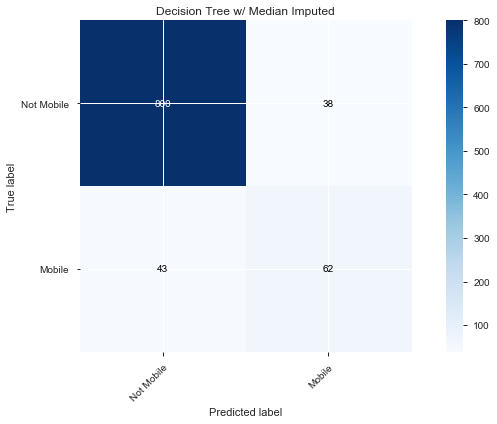

In [52]:
plot_confusion_matrix(y_imp_test, y_imp_pred, [
                      'Not Mobile', 'Mobile'], title='Decision Tree w/ Median Imputed')

#### Decision Tree 2 - Dropped

In [54]:
drop = DecisionTreeClassifier(criterion='entropy')
drop.fit(X_drop_train, y_drop_train)
y_drop_pred = drop.predict(X_drop_test)

**Performance Metrics**

In [55]:
average_precision_drop = average_precision_score(y_drop_test, y_drop_pred)
accuracy_score(y_drop_test, y_drop_pred), confusion_matrix(
    y_drop_test, y_drop_pred), average_precision_score(y_drop_test, y_drop_pred)

(0.909541511771995, array([[675,  46],
        [ 27,  59]]), 0.41895005084250353)

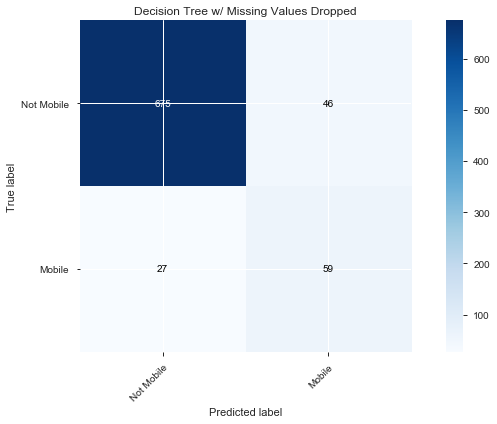

In [56]:
plot_confusion_matrix(y_drop_test, y_drop_pred, [
                      'Not Mobile', 'Mobile'], title='Decision Tree w/ Missing Values Dropped')

#### Logistic Regression - Imputed

In [72]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr_imp = LogisticRegression(
    C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr_imp.fit(np.array(X_imp_train), np.array(y_imp_train).ravel())
prediction_imp = regr_imp.predict(X_imp_test)

**Performance Metrics**

In [73]:
accuracy_score(y_imp_test, prediction_imp), average_precision_score(
    y_imp_test, prediction_imp)

(0.8048780487804879, 0.2943341304562491)

AUC: 0.8872030912603704


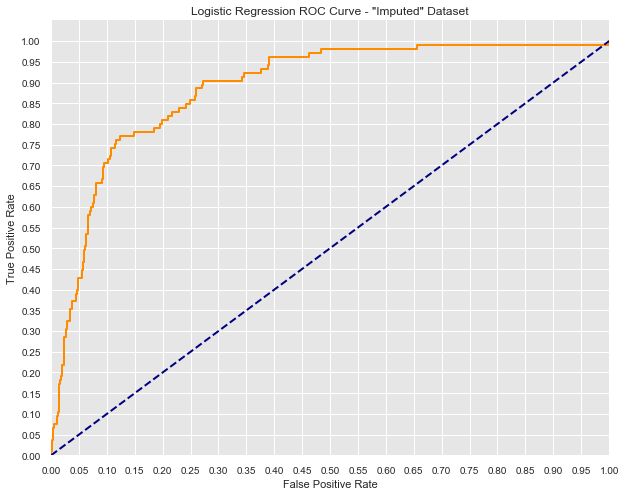

In [74]:
# ROC Curve Plotting
y_imp_score = regr_imp.fit(np.array(X_imp_train),
                             np.array(y_imp_train).ravel()).decision_function(X_imp_test)
fpr_imp, tpr_imp, thresholds_imp = roc_curve(y_imp_test, y_imp_score)
auc(fpr_imp, tpr_imp)

print('AUC: {}'.format(auc(fpr_imp, tpr_imp)))
plt.figure(figsize=(10,8))
lw=2
plt.plot(fpr_imp, tpr_imp, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve - "Imputed" Dataset')
plt.show()

In [60]:
print(classification_report(y_imp_test, prediction_imp, target_names=['Not Mobile', 'Mobile']))

              precision    recall  f1-score   support

  Not Mobile       0.97      0.81      0.88       838
      Mobile       0.34      0.80      0.48       105

    accuracy                           0.80       943
   macro avg       0.65      0.80      0.68       943
weighted avg       0.90      0.80      0.84       943



#### Logistic Regression - Dropped

In [75]:
# Using 'balanced' class_weight in the Logistic Regression instance
regr_drop = LogisticRegression(C=1e5, solver='liblinear', class_weight='balanced')

# train the model using the original training sets
regr_drop.fit(np.array(X_drop_train), np.array(y_drop_train).ravel())
prediction_drop = regr_drop.predict(X_drop_test)

**Performance Metrics**

In [76]:
accuracy_score(y_drop_test, prediction_drop), average_precision_score(y_drop_test, prediction_drop)

(0.8029739776951673, 0.30298942967335296)

AUC: 0.9048801728864948


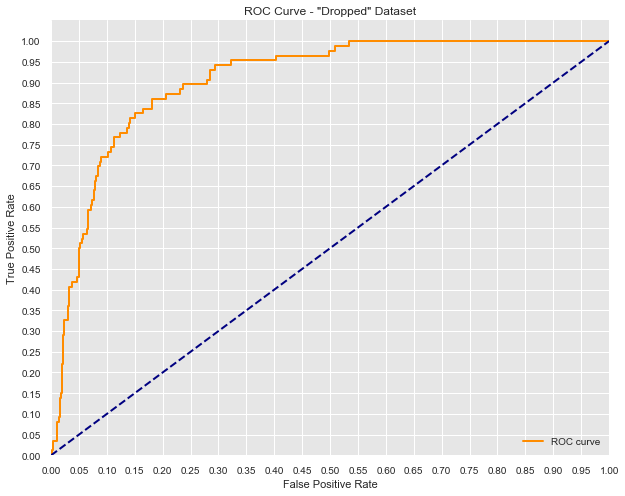

In [77]:
# ROC Curve Plotting
y_drop_score = regr_drop.fit(np.array(X_drop_train), 
                            np.array(y_drop_train).ravel()).decision_function(X_drop_test)
fpr_drop, tpr_drop, thresholds_drop = roc_curve(y_drop_test, y_drop_score)
auc(fpr_drop, tpr_drop)


print('AUC: {}'.format(auc(fpr_drop, tpr_drop)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr_drop, tpr_drop, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - "Dropped" Dataset')
plt.legend(loc="lower right")
plt.show()

#### Random Forest

Only using imputed version of data for this model. 

In [78]:
randFor = RandomForestClassifier(n_estimators=99, random_state=5)

randFor.fit(X_imp_train, y_imp_train)
rf_pred_train = randFor.predict(X_imp_train)
rf_pred_test = randFor.predict(X_imp_test)

rf_train_score = accuracy_score(y_imp_train, rf_pred_train)
rf_test_score = accuracy_score(y_imp_test, rf_pred_test)
print('Random Forest')
print("Training Accuracy: {:.2} \t\t Testing Accuracy: {:.2}".format(
    rf_train_score*100, rf_test_score*100))
print('Training Confusion Matrix\n', confusion_matrix(y_imp_train, rf_pred_train),
      '\n'+'-'*20+'\n',
      'Test Confusion Matrix\n', confusion_matrix(y_imp_test, rf_pred_test))

Random Forest
Training Accuracy: 1e+02 		 Testing Accuracy: 9.4e+01
Training Confusion Matrix
 [[1966    0]
 [   0  232]] 
--------------------
 Test Confusion Matrix
 [[827  11]
 [ 46  59]]


Using "class_weight" parameter to account for class imbalance

In [79]:
randFor = RandomForestClassifier(n_estimators=99, random_state=5, class_weight='balanced')

randFor.fit(X_imp_train, y_imp_train)
rf_pred_train = randFor.predict(X_imp_train)
rf_pred_test = randFor.predict(X_imp_test)

rf_train_score = accuracy_score(y_imp_train, rf_pred_train)
rf_test_score = accuracy_score(y_imp_test, rf_pred_test)
print('Random Forest')
print("Training Accuracy: {:.2} \t\t Testing Accuracy: {:.2}".format(rf_train_score*100, rf_test_score*100))
print('Training Confusion Matrix\n', confusion_matrix(y_imp_train, rf_pred_train), 
'\n'+'-'*20+'\n', 
'Test Confusion Matrix\n', confusion_matrix(y_imp_test, rf_pred_test))


Random Forest
Training Accuracy: 1e+02 		 Testing Accuracy: 9.4e+01
Training Confusion Matrix
 [[1966    0]
 [   0  232]] 
--------------------
 Test Confusion Matrix
 [[828  10]
 [ 50  55]]


**Performance Metrics** 

In [80]:
print(classification_report(y_imp_test, rf_pred_test, target_names=['Not Mobile', 'Mobile']))

              precision    recall  f1-score   support

  Not Mobile       0.94      0.99      0.97       838
      Mobile       0.85      0.52      0.65       105

    accuracy                           0.94       943
   macro avg       0.89      0.76      0.81       943
weighted avg       0.93      0.94      0.93       943



In [81]:
randFor_ROC = randFor.fit(np.array(X_imp_train),
                             np.array(y_imp_train).ravel()).predict_proba(X_imp_test)
fpr_imp, tpr_imp, thresholds_imp = roc_curve(y_imp_test, randFor_ROC[:,1])
auc(fpr_imp, tpr_imp)

0.9561029662461643

AUC: 0.9561029662461643


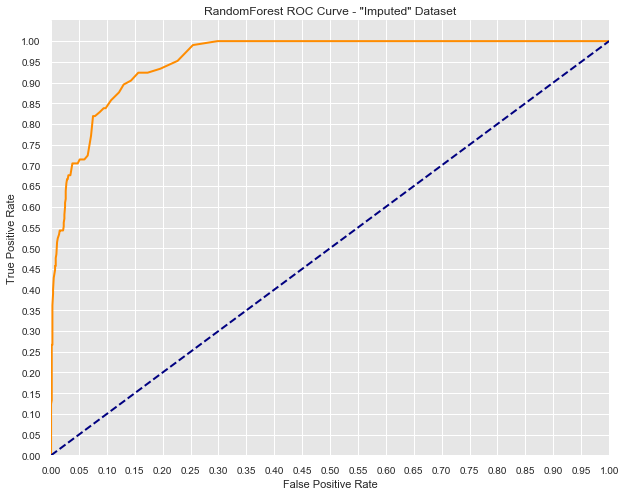

In [82]:
print('AUC: {}'.format(auc(fpr_imp, tpr_imp)))
plt.figure(figsize=(10,8))
lw=2
plt.plot(fpr_imp, tpr_imp, color='darkorange', lw=lw, label='RandomForest ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC Curve - "Imputed" Dataset')
plt.show()

**Feature Importance**

In [83]:
randFor.feature_importances_

array([0.01944416, 0.06974097, 0.16244581, 0.01682065, 0.07630195,
       0.01617481, 0.01665712, 0.02160343, 0.01928401, 0.13529357,
       0.0206655 , 0.05161591, 0.05215673, 0.02690396, 0.02376325,
       0.01810165, 0.04729636, 0.01562633, 0.02967136, 0.09897727,
       0.0276403 , 0.03381491])

In [85]:
feature_names = X_imp_test.columns
rf_feature_importance = list(zip(feature_names, randFor.feature_importances_))
sorted_rf_feature_importance = sorted(rf_feature_importance, key=itemgetter(1))
print(sorted_rf_feature_importance[:4], sorted_rf_feature_importance[-3:])

[('Preventable hospital stays', 0.015626334302003785), ('Median Parent Income', 0.016174813113475687), ('Parent Income P75', 0.016657116347674916), ('Mean Parent Income', 0.016820648285700582)] [('Unemployment', 0.09897727069799944), ('Teenage Birth Rate', 0.135293568860825), ('Share Between p25 and p75', 0.16244580665535233)]


## Results

### Confusion Matrix

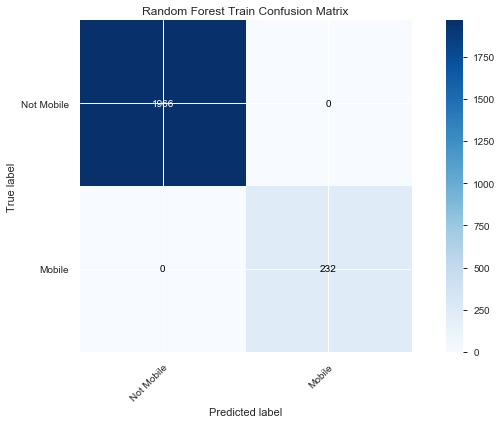

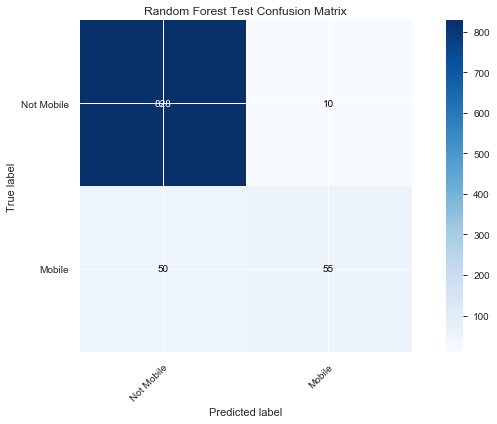

In [86]:
plot_confusion_matrix(y_imp_train, rf_pred_train, ['Not Mobile', 'Mobile'], title='Random Forest Train Confusion Matrix')
plt.show()
plot_confusion_matrix(y_imp_test, rf_pred_test, ['Not Mobile', 'Mobile'], title='Random Forest Test Confusion Matrix')
plt.show()

### Feature Correlation

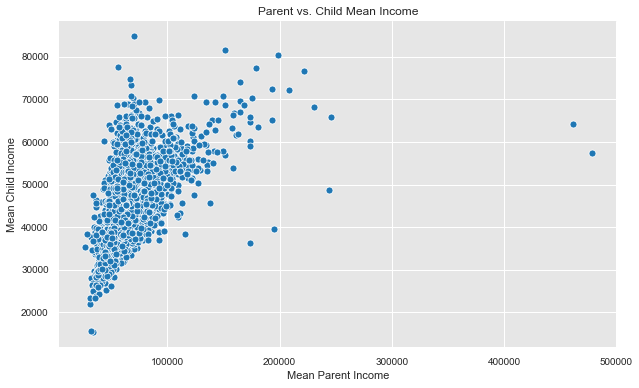

In [87]:
plt.subplots(figsize=(10,6))
sns.scatterplot(x=county_imputed['Mean Parent Income'], y=county_imputed['Mean Child Income'])
plt.title('Parent vs. Child Mean Income')
plt.show()


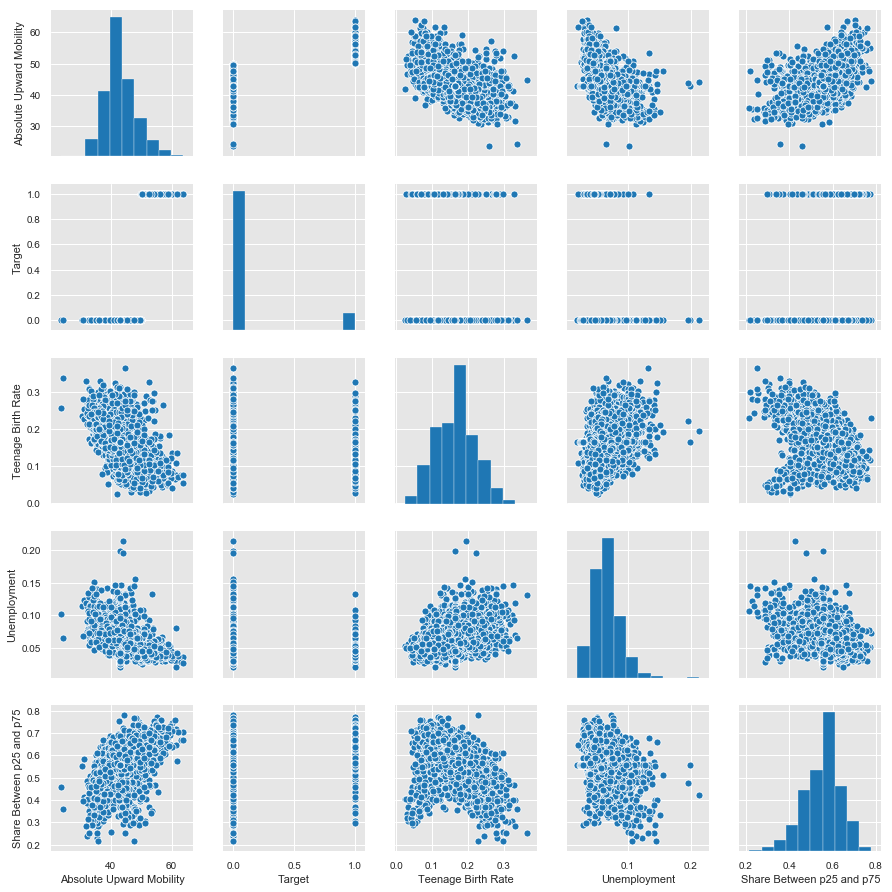

In [88]:
sns.pairplot(county_imputed[['Absolute Upward Mobility', 
                             'Target', 'Teenage Birth Rate', 
                             'Unemployment', 'Share Between p25 and p75']])



### Mapping Results

To create my map, I had to reformat the dataframe to fit the structure of the county’s GeoJSON file. This was an important step that allowed the information for each county to be dynamically called from the dataframe as a user hovers over the relevant spatial area. Full functionality of each layer is experienced when viewed singularly. (https://nateej1.github.io/AmericanDream_Geo/)

Static Image
![AUM-map](../../AUM-map-preview.png)

In [ ]:
data_imp = pd.read_pickle('../../data/03_processed/county_merged_imputed')
lat_lon = pd.read_csv('../../data/01_raw/lat_lon_counties.csv')

# lat_lon.columns

lat_lon['FIPS ']=lat_lon['FIPS '].apply(lambda x: str(x).zfill(5))
lat_lon_sub = lat_lon[['FIPS ', 'Latitude ', 'Longitude', 'State', 'County ']]
lat_lon_sub.rename(columns={'FIPS ': 'fips', 
                            'Latitude ': 'lat',
                            'Longitude': 'lon', 
                            'State': 'state', 
                            'County': 'county'}, 
                   inplace=True)

total = data_imp.merge(lat_lon_sub[['lat','lon']], how='outer', left_index=True,
    right_index=True )
lat_lon_sub.set_index('fips', inplace=True)
total['County FIPS Code'] = total['County FIPS Code'].apply(lambda x: '0500000US'+str(x))

#total.to_pickle('../../data/03_processed/county_imp_geo')

**Manipulating Dataframe & GeoJSON files for map display**  
*sourced from notebook in notebooks/02_processing of the same name*

In [ ]:
## GeoJSON shape files

us_county_json = '../../data/01_raw/gz_2010_us_050_00_500k.json'
with open(us_county_json, encoding="ISO-8859-1") as json_file:
    county_json = json.loads(json_file.read())
    
## County metrics 
data_imp = pd.read_pickle('../../data/03_processed/county_imp_geo')

# county_json["features"][0]['properties'].keys()
data_imp['% Top 1% Income Share'] = round(((data_imp['Top 1% Income Share'])*100),2).astype('str')+'%'
data_imp['% Unemployment'] = round(((data_imp['Unemployment'])*100),2).astype('str')+'%'
data_imp['% Teenage Birth Rate'] = round(((data_imp['Teenage Birth Rate'])*100),2).astype('str')+'%'
data_imp['% Share Between p25 and p75'] = round(((data_imp['Share Between p25 and p75'])*100),2).astype('str')+'%'

data_dict = data_imp.to_dict(orient='records')
updated_county_json = county_json
for county in range(len(data_dict)):
    for idx in range(len(updated_county_json['features'])):
        if data_dict[county]['County FIPS Code'] == updated_county_json['features'][idx]['properties']['GEO_ID']:
            updated_county_json['features'][idx]['properties'].update(data_dict[county])
        else: pass
        
# data_imp.to_pickle('../../data/03_processed/all_county_metrics')
# pickle.dump(updated_county_json, open('../../data/03_processed/county_metrics_and_shapefiles.p', 'wb'))


In [ ]:
# Instantiating map object
aum_map = folium.Map(location=[37, -95], zoom_start=5)
bins = list(data_imp['Absolute Upward Mobility'].quantile([0, 0.25, 0.5, 0.75, 1]))

choro = folium.Choropleth(
    geo_data=updated_county_json,
    data=data_imp,
    columns=['County FIPS Code', 'Absolute Upward Mobility'],
    key_on='properties.GEO_ID',
    fill_color='YlOrRd',
    fill_opacity=0.5,
    nan_fill_color='gray',
    nan_fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Absolute Upward Mobility',
    bins=bins,
    reset=True, 
    highlight=True,
    name='Absolute Upward Mobility'
    
)

choro2 = folium.Choropleth(
    geo_data=updated_county_json,
    data=data_imp,
    columns=['County FIPS Code', 'Target'],
    key_on='properties.GEO_ID',
    fill_color='PuBu',
    fill_opacity=0.5,
    nan_fill_color='gray',
    nan_fill_opacity=0.9,
    line_opacity=0.5,
    legend_name='Mobility Outcomes',
    bins=3,
    reset=True, 
    highlight=True,
    name='Child Can Move atleast 1 quartile up'
    )

locations = list(zip(data_imp.lat, data_imp.lon))
popup_content = list(zip(data_imp['County Name'], data_imp['State'], round(data_imp['Absolute Upward Mobility'],1), round(data_imp['Teenage Birth Rate']*100, 1)
                         ))
popups = ['<center> {} County, {} <br>  <b>AUM:</b> {} <br><b>Teen Birth Rate:</b> {}% <br>'.format(
    name, state, aum, share) for (name, state, aum, share) in popup_content]


tooltip = folium.features.GeoJsonTooltip(fields=['NAME', 'State', 'Absolute Upward Mobility', '% Unemployment', '% Teenage Birth Rate', '% Share Between p25 and p75'],
                                         aliases=[
                                             'County', 'State', 'Absolute Upward Mobility', 'Unemployment Rate','Teen Birth Rate', '"Middle Class" Income Share'],
                                         style=('background-color: grey; color: white; font-family:'
                                                'courier new; font-size: 24px; padding: 10px;'),
                                         localize=True)

choro.geojson.add_child(tooltip)

data_imp_copy = data_imp.reset_index()

for idx, row in data_imp_copy.iterrows():
    if row['Absolute Upward Mobility'] >= 60:
        location = locations[idx][0], locations[idx][1]
        marker = folium.Marker(location=location)    
        popup = popups[idx]
        folium.Popup(popup, max_width='150%').add_to(marker)
        icons = folium.Icon(color='green', icon='ok-sign').add_to(marker)
        marker.add_to(choro2)
    elif row['Absolute Upward Mobility'] <= 32:
        location = locations[idx][0], locations[idx][1]
        marker = folium.Marker(location=location)    
        popup = popups[idx]
        folium.Popup(popup, max_width='150%').add_to(marker)
        icons = folium.Icon(color='red').add_to(marker)
        marker.add_to(choro2)
    else: pass

    
choro.add_to(aum_map)
choro2.add_to(aum_map)
folium.LayerControl().add_to(aum_map)
aum_map.save(os.path.join('../../results', 'aum_map8.html'))

## Conclusions and Next Steps

With more robust datasets, this analysis could inform policy decisions that can foster more equitable environments for upward mobility. 

In continuing this investigation, I would like to incorporate education data from Urban Institute, create a map product with more interactive features, allowing the audience to engage in their own exploration of the topic (using Dash)